# 4.10 Time Series Forecast


**Chronos Test**

In this example, we will test Chronos on canonical geoscientific data sets chosen to be representative of geoscience/geophysics:
1. earthquake catalogs from SoCal
2. earthquake ground motion waveforms
3. near surface properties (seismic velocities, temperature, soil moisture)
4. ice velocity from greenland
5. GPS positions along a plate boundary that captures seasons and tectonic loading.
The data files are gathered on this repository: https://github.com/UW-MLGEO/MLGeo-dataset

The data has been prepared as CSV files with times series.
The forescasts are added to the CSV files under key attributes "Chronos-zero-shot".


Limitations by [Chronos](https://arxiv.org/pdf/2403.07815). Chronos uses large language models at its core for forecasting time series. The time series is "tokenized" to convert from an array of floats into contect tokens.


By Marine Denolle (mdenolle@uw.edu)


In [ ]:
! pip install chronos-forecasting

In [1]:
import torch
torch.cuda.empty_cache()
import gc
gc.collect()

0

In [2]:
import matplotlib.pyplot as plt
import torch
from chronos import ChronosPipeline, ChronosBoltPipeline
import pandas as pd
import numpy as np


# Set the font style and size
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'sans-serif',
    'font.serif': ['DejaVu Sans'],
    'axes.titlesize': 12,
    'axes.labelsize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10
})


In [ ]:
# benchmarking with ARIMA
!pip install statsmodels
from statsmodels.tsa.arima.model import ARIMA

# Assuming df is your DataFrame and 'datetime' is your datetime column
# df["datetime"] = pd.to_datetime(df["datetime"])
# df.set_index("datetime", inplace=True)

# # Assuming 'value' is the column you want to forecast
# data = df['value']

# Fit ARIMA model
# model = ARIMA(data, order=(5, 1, 0))  # (p, d, q) order, adjust as needed
# model_fit = model.fit()

# # Make predictions
# forecast_steps = 10  # Number of steps to forecast
# forecast = model_fit.forecast(steps=forecast_steps)

# # Plot the results
# plt.figure(figsize=(10, 6))
# plt.plot(data, label='Actual')
# plt.plot(forecast, label='Forecast', color='red')
# plt.legend()
# plt.show()

# # Print forecasted values
# print(forecast)

In [3]:
n_timeseries = 20

In [4]:
pipeline = ChronosBoltPipeline.from_pretrained(
    "amazon/chronos-bolt-base",
    device_map="cuda",  # use "cpu" for CPU inference and "mps" for Apple Silicon
    torch_dtype=torch.bfloat16,
)

In [5]:
from chronos import BaseChronosPipeline, ChronosPipeline, ChronosBoltPipeline

print(BaseChronosPipeline.predict.__doc__)  # for Chronos models
print(ChronosPipeline.predict.__doc__)  # for Chronos models


        Get forecasts for the given time series. Predictions will be
        returned in fp32 on the cpu.

        Parameters
        ----------
        context
            Input series. This is either a 1D tensor, or a list
            of 1D tensors, or a 2D tensor whose first dimension
            is batch. In the latter case, use left-padding with
            ``torch.nan`` to align series of different lengths.
        prediction_length
            Time steps to predict. Defaults to a model-dependent
            value if not given.

        Returns
        -------
        forecasts
            Tensor containing forecasts. The layout and meaning
            of the forecasts values depends on ``self.forecast_type``.
        

        Get forecasts for the given time series.

        Refer to the base method (``BaseChronosPipeline.predict``)
        for details on shared parameters.

        Additional parameters
        ---------------------
        num_samples
            Number of s

In [6]:

print(ChronosBoltPipeline.predict.__doc__)  # for Chronos-Bolt models


        Get forecasts for the given time series.

        Refer to the base method (``BaseChronosPipeline.predict``)
        for details on shared parameters.
        Additional parameters
        ---------------------
        limit_prediction_length
            Force prediction length smaller or equal than the
            built-in prediction length from the model. False by
            default. When true, fail loudly if longer predictions
            are requested, otherwise longer predictions are allowed.

        Returns
        -------
        torch.Tensor
            Forecasts of shape (batch_size, num_quantiles, prediction_length)
            where num_quantiles is the number of quantiles the model has been
            trained to output. For official Chronos-Bolt models, the value of
            num_quantiles is 9 for [0.1, 0.2, ..., 0.9]-quantiles.

        Raises
        ------
        ValueError
            When limit_prediction_length is True and the prediction_length is
    

Some functions

In [8]:
def reshape_time_series(df, name_of_target="count" ,n_timeseries=20, duration_years=2):
    """
    Generate a list of time series from the given DataFrame.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing a 'datetime' column.
    n_timeseries (int): Number of time series to generate.
    duration_years (int): Duration of each time series in years.
    resample_period (str): Resampling period (e.g., 'D' for daily).

    Returns:
    list: A list of DataFrames, each containing a time series.
    pd.DataFrame: A wide-format DataFrame containing the time series.
    """
    df_list = [pd.DataFrame() for _ in range(n_timeseries)]
    kk = 0
    while kk < n_timeseries:
        start_date = df["datetime"].sample().values[0]
        start_date = pd.to_datetime(start_date)
        # Create a time series for the specified duration
        end_date = start_date + pd.DateOffset(years=duration_years)
        if end_date > df["datetime"].max():
            continue    # Skip if the end date exceeds the maximum date in the catalog
        # Create a time series from the catalog and select only the date time and target columns
        time_series = df[(df["datetime"] >= start_date) & (df["datetime"] <= end_date)][["datetime", name_of_target]]
        time_series = time_series.set_index("datetime")
        # time_series = time_series.resample(resample_period).mean().interpolate() # resample and interpolate
        time_series = time_series.ffill()#(method="ffill") # forward fill
        time_series = time_series.bfill()#(method="bfill") # backward fill
        time_series = time_series.reset_index()# reset index to keep datetime as a column
        # remove the "datetime" column to the time_series
        
        df_list[kk] = time_series
        kk += 1 
    df_list_count = [pd.DataFrame() for _ in range(n_timeseries)]
    for ik in range(n_timeseries):
        df_list_count[ik] = df_list[ik][name_of_target]
        df_list_count[ik] = df_list_count[ik].rename(f"target_{ik}")
    df_wide = pd.concat(df_list_count, axis=1)

    # find the sampling rate dt as the difference between the first two dates
    dt = df["datetime"].diff().dt.total_seconds().fillna(0).mean()
    # convert dt to days
    dt = dt / (24 * 3600)
    print("sampling rate {:.2f} days".format(dt))

    # create a time array that is the index of the time series and convert the dae
    df_wide["time_index"] = np.arange(len(df_wide)) #* pd.Timedelta(days=dt)
    # move the last column to the first position
    cols = df_wide.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    df_wide = df_wide[cols]

    # rename columns to target_ID except for the first column that is a datetime
    df_wide.columns = [f"target_{i}" if i != 0 else "time_index" for i in range(len(df_wide.columns))]
    df_wide = df_wide.dropna() 
    
    return df_list, df_wide

# Example usage:
# df_list,df_wide = reshape_time_series(df, n_timeseries=20, duration_years=2, resample_period='D')

In [9]:
def predict_chronos(df, predict_length=64, n_timeseries=20):
    """
    Make predictions for the given time series data.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing the time series data.

    Returns:
    forecast_mean (np.array): The mean forecasted values for the time series.
    lower_bound (np.array): The 5% lower bound of the forecasted values.
    upper_bound (np.array): The 95% upper bound of the forecasted values.
    mean_mae (float): The mean absolute error of the forecasted values.
    no_var_mae (float): The mean absolute error assuming no change in the time series.


    """
    # Ensure df['Date'] is in datetime format
    # df['datetime'] = pd.to_datetime(df['datetime'])

    # Select the first n_timeseries columns for forecasting
    columns_to_forecast = df.columns[1:n_timeseries+1]  # +1 to skip the 'Date' column

    # Calculate the split index for training
    split_index = int(len(df) - predict_length)

    # Split the data into training and evaluation sets for all selected columns
    train_data = df[columns_to_forecast].iloc[:split_index]
    eval_data = df[columns_to_forecast].iloc[split_index:]

    # Convert the training data to a higher-dimensional tensor
    train_tensor = torch.tensor(train_data.values, dtype=torch.float32).T
    # Perform the forecasting using the training data
    # forecast = pipeline.predict(
    #     context=train_tensor,
    #     prediction_length=len(eval_data),  # Predict the same length as the evaluation set
    #     num_samples=50,
    # )
    forecast = pipeline.predict(
        context=train_tensor,
        prediction_length=len(eval_data))  # Predict the same length as the evaluation set
    # )

    # Take the mean across the samples (axis=1) for each time series
    forecast_mean = forecast.mean(dim=1).squeeze().numpy()
    # lower_bound = forecast.quantile(0.05, dim=1).squeeze().numpy()
    # upper_bound = forecast.quantile(0.95, dim=1).squeeze().numpy()


    mae=[]
    # Calculate and print the MAE for each time series
    for i, column_name in enumerate(columns_to_forecast):
        # Calculate MAE for the current time series
        mae.append (np.mean(np.abs(forecast_mean[i]- eval_data[column_name].values)))
        
        # Print the MAE
        print(f'Mean Absolute Error (MAE) for {column_name}: {mae[-1]}')

    mean_mae = np.array(mae).mean()
    print(f'Mean of forecast MAEs = {mean_mae}')

    # Calculate and print the MASE for each time series
    mase=[]
    for i, column_name in enumerate(columns_to_forecast):
        # Calculate MASE for the current time series
        mase.append (np.mean(np.abs(forecast_mean[i] - eval_data[column_name].values)) / np.mean(np.abs(eval_data[column_name].values[1:] - eval_data[column_name].values[:-1])))
        
        # Print the MASE
        print(f'Mean Absolute Scaled Error (MASE) for {column_name}: {mase[-1]}')

    mean_mase = np.array(mase).mean()
    print(f'Mean of forecast MAEs = {mean_mase}')


    # Baseline model: ARIMA
    mae_arima=[]
    # Calculate and print the MAE for each time series
    for i, column_name in enumerate(columns_to_forecast):
        # Calculate MAE for the current time series
        mae_arima.append (np.mean(np.abs(eval_data[column_name].values[-1] - eval_data[column_name].values)))
        
        # Print the MAE
        # print(f'MAE assuming d/dt=0 for {column_name}: {mae_nochangemodel[-1]}')

    mae_arima_mean = np.array(mae_arima).mean()
    print(f'Mean of ARIMA MAEs = {mae_arima_mean}')

    return forecast,mean_mae, mean_mase, mae_arima_mean, split_index

In [10]:
import matplotlib.dates as mdates
def plot_forecasts(df_wide,split_index,forecast,n_timeseries,field="count",filename="geo-forecast.png"):
    """
    Plot the forecasted values along with the confidence intervals.

    Parameters:
    n_timeseries (int): Number of time series to plot.
    df_wide (pd.DataFrame): The wide-format DataFrame containing the time series.
    split_index (int): The index at which the training data ends (or context data) and evaluation (or forecast) data begins.
    forecast (np.array): The forecasted values for the time series.
    filename (str): The filename to save the plot.


    Returns:
    None


    """
    
    # Determine the number of rows and columns for the subplots
    n_timeseries = min(n_timeseries, 12)  # Cap the number of time series to 12
    nrows = (n_timeseries - 1) // 3 + 1
    ncols = min(n_timeseries, 3)

    # Select the first n_timeseries columns for forecasting
    columns_to_forecast = df_wide.columns[1:n_timeseries+1]  # +1 to skip the 'Date' column
    print(forecast.shape)
    forecast_mean = forecast.mean(dim=1).squeeze()
    print(forecast_mean.shape)
    lower_bound = np.percentile(forecast, 5, axis=0)
    upper_bound = np.percentile(forecast, 95, axis=0)

    # Layout the subplots
    fig, axes = plt.subplots(nrows, ncols, figsize=(20, 16), sharex=True)
    # Flatten the 2D array of axes for easy indexing
    if n_timeseries>1:
        axes = axes.flatten()
    else:
        axes = [axes]
        


    # Split the data into training and evaluation sets for all selected columns
    # train_data = df_wide[columns_to_forecast].iloc[:split_index]
    eval_data = df_wide[columns_to_forecast].iloc[split_index:]


    # Calculate and print the MASE for each time series
    mase=[]
    for i, column_name in enumerate(columns_to_forecast):
        # Calculate MASE for the current time series
        mase.append (np.mean(np.abs(forecast_mean[i].numpy()  - eval_data[column_name].values)) / np.mean(np.abs(eval_data[column_name].values[1:] - eval_data[column_name].values[:-1])))
        
    mean_mase = np.array(mase).mean()
    print(f'Mean of forecast MASEs = {mean_mase}')
    print(n_timeseries)
    # Iterate over the first n_timeseries and plot
    if n_timeseries>1:
        for i, column_name in enumerate(columns_to_forecast[0:n_timeseries]):
            # Plot the original data
            axes[i].plot(df_wide['time_index'], df_wide[column_name], label='Original Data')
            
            # Calculate the 5th and 95th percentiles for the confidence interval
            lower_bound = np.percentile(forecast[i, :, :], 5, axis=0)
            upper_bound = np.percentile(forecast[i, :, :], 95, axis=0)
            
            # Plot the forecast
            axes[i].plot(df_wide['time_index'].iloc[split_index:], forecast_mean[i], label='Forecast')
            
            # Plot the confidence intervals
            axes[i].fill_between(df_wide['time_index'].iloc[split_index:], lower_bound, upper_bound, 
                                color='r', alpha=0.2, label='95% CI')


            # set the x-axis labels as the number of days
            # axes[i].set_xticks(np.arange(0,len(df_wide['datetime']), step=30))
            axes[i].grid(True, which='both', axis='both', linestyle='--', linewidth=0.5, color='gray')

            # Plot the evaluation data for reference
            # axes[i].plot(df_wide['datetime'].iloc[split_index:], eval_data[column_name].values, '--', label='Evaluation Data')

            # Format the subplot
            axes[i].set_title(f'{field} {i} , MASE={mase[i]:.2f}')
            axes[i].set_ylabel(field)
            axes[i].set_xlabel('Time Index')
            if i==0: axes[i].legend()

            # Apply x-tick rotation
            # axes[i].xaxis.set_major_locator(mdates.AutoDateLocator())
            # axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
            axes[i].tick_params(axis='x', rotation=45)
            # axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
            # convert the x-labels to days every month
            # axes[i].xaxis.set_major_locator(plt.MaxNLocator(6))
    else:
        # Plot the original data
        axes[i].plot(df_wide['time_index'], df_wide[column_name], label='Original Data')
        
        # Calculate the 5th and 95th percentiles for the confidence interval
        lower_bound = np.percentile(forecast[i, :, :], 5, axis=0)
        upper_bound = np.percentile(forecast[ i, :, :], 95, axis=0)
        print(forecast_mean.shape)
        # Plot the forecast
        axes[i].plot(df_wide['time_index'].iloc[split_index:], forecast_mean, label='Forecast')
        
        # Plot the confidence intervals
        axes[i].fill_between(df_wide['time_index'].iloc[split_index:], lower_bound, upper_bound, 
                            color='r', alpha=0.2, label='95% CI')


        # set the x-axis labels as the number of days
        # axes[i].set_xticks(np.arange(0,len(df_wide['datetime']), step=30))
        axes[i].grid(True, which='both', axis='both', linestyle='--', linewidth=0.5, color='gray')

        # Plot the evaluation data for reference
        # axes[i].plot(df_wide['datetime'].iloc[split_index:], eval_data[column_name].values, '--', label='Evaluation Data')

        # Format the subplot
        axes[i].set_title(f'{field} {i} , MASE={mase[i]:.2f}')
        axes[i].set_ylabel(field)
        axes[i].set_xlabel('Time Index')
        if i==0: axes[i].legend()

        # Apply x-tick rotation
        # axes[i].xaxis.set_major_locator(mdates.AutoDateLocator())
        # axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        axes[i].tick_params(axis='x', rotation=45)




    # Remove empty subplots if n_timeseries < 8
    for j in range(i + 1, nrows * ncols):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.savefig(filename)
    # also save a SVG 
    plt.savefig(filename.replace('.png','.svg'))
    plt.show()


    # add a column to df_wide with the predictions for each target_{i} labels at the rows of the evaluation data
    for i, column_name in enumerate(columns_to_forecast):
        df_wide.loc[df_wide.index[split_index:], f'forecast_{i}'] = forecast_mean[i].numpy()

    # store the new df_wide with the precition into a new CSV files that takes the filename of the original file
    df_wide.to_csv(filename.replace('.png','.csv'), index=False)

    return

In [11]:
# Quick plot
def quick_plot(df_wide,n_timeseries,field="count",dt=1):
    """
    Quick plot of the time series data.

    Parameters:
    df_wide (pd.DataFrame): The wide-format DataFrame containing the time series.
    n_timeseries (int): Number of time series to plot.
    field (str): The field to plot.


    Returns:
    None
    """
    # Determine the number of rows and columns for the subplots
    n_timeseries2 = min(n_timeseries, 6)  # Cap the number of time series to 12
    nrows = (n_timeseries2 - 1) // 3 + 1
    ncols = min(n_timeseries2, 3)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(11, 8))  # define the figure and subplots
    axes = axes.ravel()
    for i in range(n_timeseries2):
        # create a time axis that multiplies time_data by dt
        # Calculate the time index as the difference from the first datetime
        # df_wide['time_index'] = (df_wide['time_index'] - df_wide['time_index'].iloc[0]).dt.total_seconds() / (24 * 3600)

        # Convert the time_index to a float array
        time_index_days_float = df_wide['time_index'].values


      
        ax = axes[i]
        ax.plot(time_index_days_float, df_wide[f"target_{i+1}"], label=f"{field}_{i+1}")
        ax.set_title(f"{field} {i}")
        ax.set_xlabel("Days")
        ax.set_ylabel(field)
        plt.tight_layout()
        ax.grid()

    plt.show()

## Earthquake Data


In [12]:
# first we load data/data_qtm_catalog.csv
df = pd.read_csv("../data/data_qtm_catalog.csv")
df.head()

,datetime,count
0,2008-01-01,120
1,2008-01-02,89
2,2008-01-03,146
3,2008-01-04,166
4,2008-01-05,94


In [13]:
# calculate the time difference between each datetime to set up the dt
# convert the datetime column to datetime object
df["datetime"] = pd.to_datetime(df["datetime"])
dt = df["datetime"].diff().dt.total_seconds().fillna(0).mean()
# convert seconds to days
dt = np.ceil(dt / (60 * 60 * 24))
print(dt)

1.0


## Reshape for Prediction

In [14]:
# randomly cut the long time series into n_timeseries, stored in data frames.
df_list,df_wide = reshape_time_series(df, name_of_target="count", n_timeseries=n_timeseries, duration_years=2)

sampling rate 1.00 days


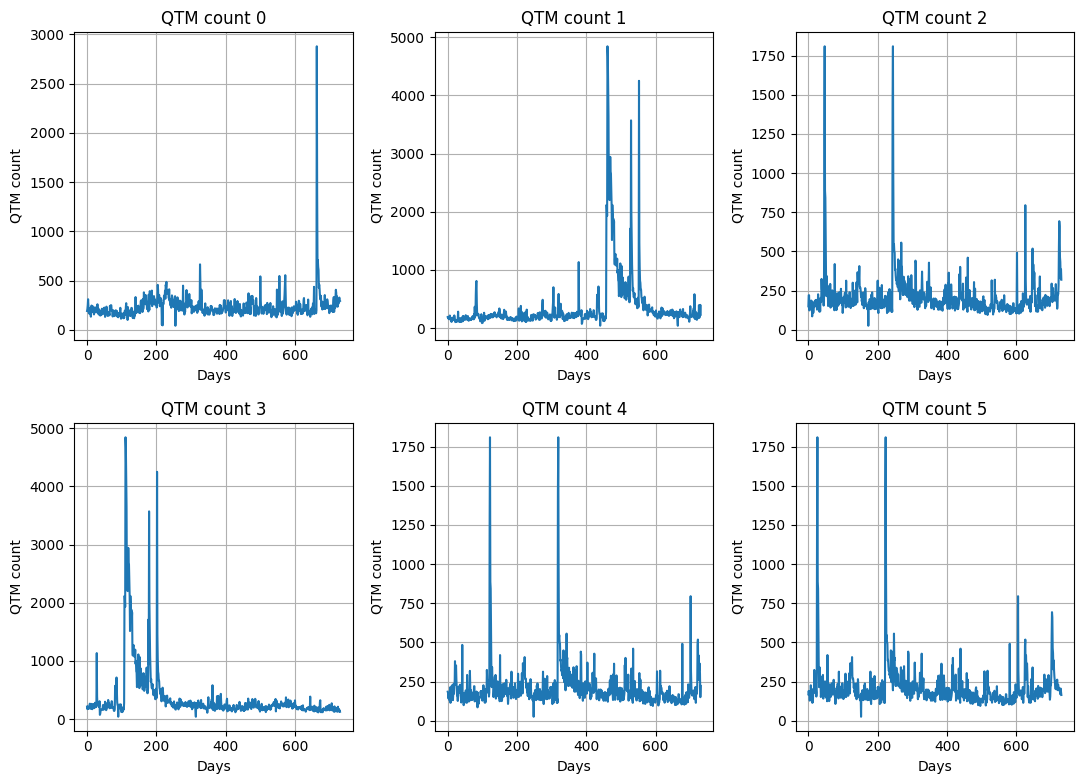

In [15]:
quick_plot(df_wide,n_timeseries,field="QTM count",dt=1)

### Predict with Chronos & Plot

Mean Absolute Error (MAE) for target_1: 48.48504137992859
Mean Absolute Error (MAE) for target_2: 50.47730255126953
Mean Absolute Error (MAE) for target_3: 73.13016510009766
Mean Absolute Error (MAE) for target_4: 29.68954849243164
Mean Absolute Error (MAE) for target_5: 65.26891136169434
Mean Absolute Error (MAE) for target_6: 68.76318144798279
Mean Absolute Error (MAE) for target_7: 35.08878254890442
Mean Absolute Error (MAE) for target_8: 57.32973098754883
Mean Absolute Error (MAE) for target_9: 45.120017528533936
Mean Absolute Error (MAE) for target_10: 53.568915605545044
Mean Absolute Error (MAE) for target_11: 37.61477780342102
Mean Absolute Error (MAE) for target_12: 110.07398819923401
Mean Absolute Error (MAE) for target_13: 39.093090534210205
Mean Absolute Error (MAE) for target_14: 80.03271508216858
Mean Absolute Error (MAE) for target_15: 67.37908172607422
Mean Absolute Error (MAE) for target_16: 43.82308888435364
Mean Absolute Error (MAE) for target_17: 192.06181573867798
M

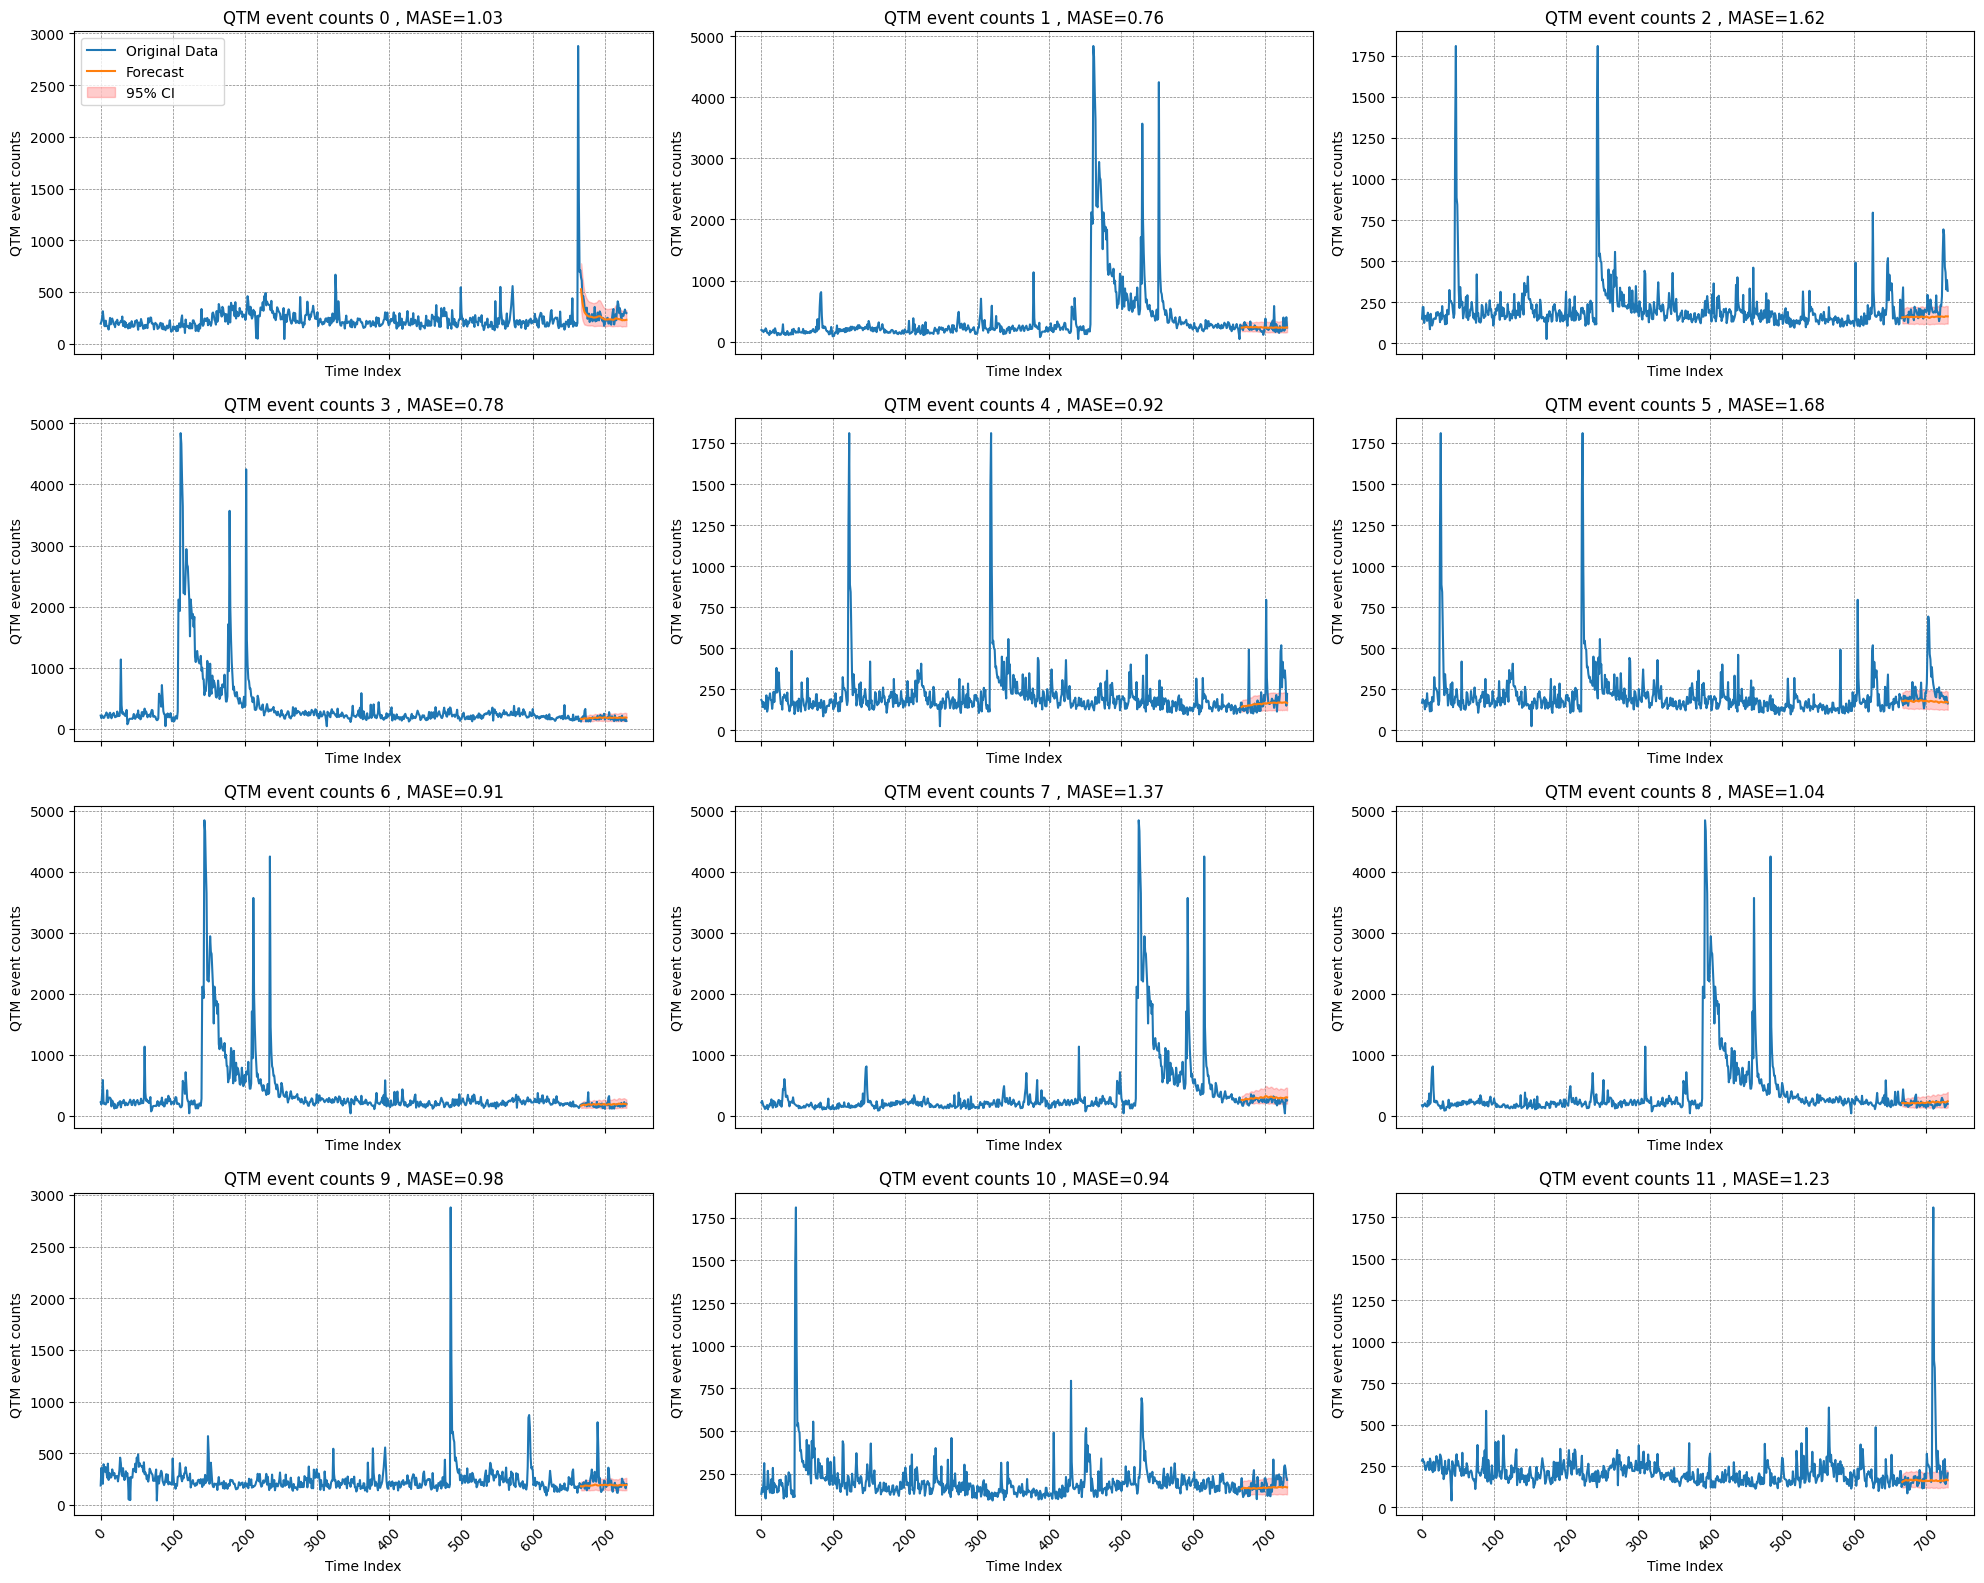

In [16]:
forecast, mean_mae, mean_mase, no_var_mae, split_index = predict_chronos(df_wide,n_timeseries=n_timeseries)
# plot forecast
plot_forecasts(df_wide,split_index,forecast,n_timeseries,field="QTM event counts",filename="./plots/quake_qtm_forecast.png")
# save a vectorized plot

In [17]:
df_wide.head()

,time_index,target_1,target_2,target_3,target_4,target_5,target_6,target_7,target_8,target_9,...,forecast_2,forecast_3,forecast_4,forecast_5,forecast_6,forecast_7,forecast_8,forecast_9,forecast_10,forecast_11
0,0,193,191.0,149.0,216.0,185.0,168.0,223.0,220.0,175.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,212,180.0,220.0,173.0,176.0,190.0,188.0,246.0,150.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,250,183.0,220.0,218.0,142.0,171.0,368.0,205.0,181.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,312,155.0,123.0,199.0,172.0,173.0,588.0,159.0,176.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,242,184.0,163.0,177.0,146.0,128.0,202.0,153.0,207.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
!pip install statsmodels
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

667    170.875002
668    109.156006
669    134.097091
670    115.263988
671    123.108176
          ...    
726    -36.171929
727    -35.465038
728    -41.488969
729    -41.760654
730    -47.384863
Name: predicted_mean, Length: 64, dtype: float64
64
Mean Absolute Scaled Error (MASE) for ARIMA: 4.420838227473031


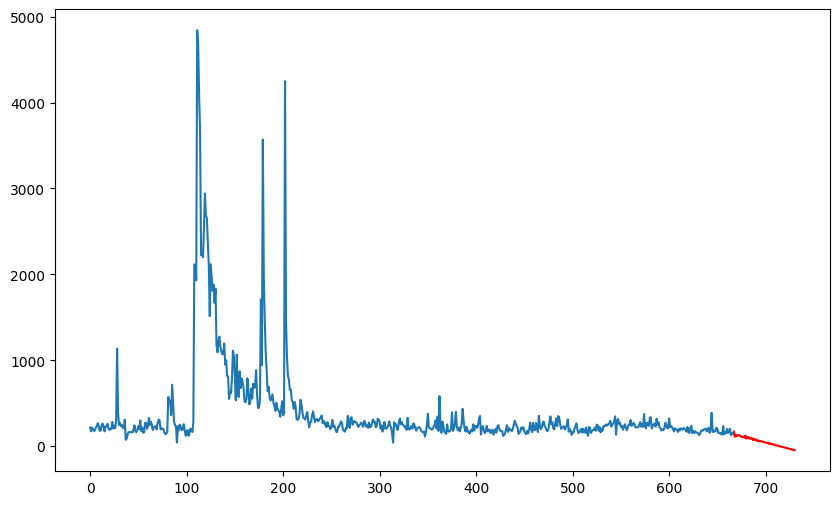

In [23]:
# benchmarking with ARIMA
# Fit ARIMA model
data = df_wide['target_4'][:split_index]
model = ARIMA(data, order=(25, 2, 0))  # (p, d, q) order, adjust as needed
model_fit = model.fit()

# Make predictions
forecast_steps = 64  # Number of steps to forecast
forecast = model_fit.forecast(steps=forecast_steps)

split_index = len(df_wide['target_3'].values) - 64
print(forecast) 
# calculate the MASE between the forecast and the evaluation data
mase=[]
eval_data = df_wide['target_1'][split_index:]
print(len(df_wide['target_1'].values[split_index:]))
# Calculate and print the MASE for each time series
mase.append(np.mean(np.abs(forecast - df_wide['target_1'].values[split_index:])) / np.mean(np.abs(df_wide['target_1'].values[1:] - df_wide['target_1'].values[:-1])))
# print mase
print(f'Mean Absolute Scaled Error (MASE) for ARIMA: {mase[-1]}')

                 

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(data, label='Actual')
plt.plot(forecast, label='Forecast', color='red')


## 2. Icesheet velocities

Now we test the time series of icesheet velocities in Greenland. This is work done by Brad Lipovsky.

In [24]:

'''
Read the data
'''
df = pd.read_csv('../data/data_ice_jakobshavn.csv',na_values=[-1])


In [25]:
# calculate the time difference between each datetime to set up the dt
# convert the datetime column to datetime object
df["datetime"] = pd.to_datetime(df["Date"])
dt = df["datetime"].diff().dt.total_seconds().fillna(0).mean()
# convert seconds to days
dt = np.ceil(dt / (60 * 60 * 24))
print("sampling rate {} days".format(dt))

sampling rate 8.0 days


### Reshape for prediction

In [26]:
df_wide = df
df_wide.dropna()

,Date,"Pixel Value (x=2500, y=8200)","Pixel Value (x=2500, y=8201)","Pixel Value (x=2500, y=8202)","Pixel Value (x=2500, y=8203)","Pixel Value (x=2500, y=8204)","Pixel Value (x=2500, y=8205)","Pixel Value (x=2500, y=8206)","Pixel Value (x=2500, y=8207)","Pixel Value (x=2500, y=8208)",...,"Pixel Value (x=2509, y=8201)","Pixel Value (x=2509, y=8202)","Pixel Value (x=2509, y=8203)","Pixel Value (x=2509, y=8204)","Pixel Value (x=2509, y=8205)","Pixel Value (x=2509, y=8206)","Pixel Value (x=2509, y=8207)","Pixel Value (x=2509, y=8208)","Pixel Value (x=2509, y=8209)",datetime
0,2015-01-01,2690.5570,2682.3616,2658.6174,2606.9355,2530.3400,2432.4604,2337.5603,2238.3130,2131.6187,...,1860.1473,1811.2555,1772.2811,1739.5938,1691.1827,1651.6400,1610.4110,1563.1417,1513.4183,2015-01-01
1,2015-01-13,2714.7678,2694.3774,2657.5322,2604.6094,2541.0916,2492.7390,2451.3862,2415.7693,2235.5337,...,1866.2997,1801.4703,1747.1519,1679.1748,1619.7880,1580.2765,1548.2367,1506.4203,1471.4894,2015-01-13
2,2015-01-25,2712.4210,2724.5880,2735.8308,2645.3513,2518.3074,2460.4731,2262.7056,2141.2844,2034.8848,...,1807.4071,1738.1703,1679.8862,1627.8777,1575.1526,1554.8282,1534.6147,1520.7195,1515.0082,2015-01-25
4,2015-02-18,2641.4170,2613.6772,2577.1538,2528.2330,2444.6372,2356.7375,2280.1716,2216.3354,2187.7751,...,1803.6461,1748.5105,1696.6669,1643.1813,1591.3317,1547.9862,1504.9419,1459.6843,1411.1000,2015-02-18
5,2015-03-02,2695.7231,2654.4783,2596.1223,2527.4956,2450.6010,2383.8125,2317.7700,2231.7078,2069.8728,...,1768.4241,1721.1057,1695.4995,1661.2021,1618.2247,1578.6671,1531.1387,1487.0217,1451.7004,2015-03-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437,2024-02-25,2355.7673,2317.1812,2267.6526,2218.5762,2174.4893,2119.7183,2036.1709,1886.2402,1742.2327,...,1555.8588,1496.1707,1448.4729,1410.3757,1372.7169,1332.9342,1291.7050,1252.8741,1215.6035,2024-02-25
438,2024-03-08,2356.8071,2318.0103,2271.4500,2208.3280,2131.2380,2038.9028,1941.8640,1839.1848,1730.7375,...,1584.8710,1545.4580,1487.4086,1430.3809,1381.1884,1338.1537,1301.4970,1264.5914,1226.1100,2024-03-08
439,2024-03-20,2369.9165,2318.2954,2239.7700,2166.4363,2106.1460,2046.7198,1997.2346,1934.0216,1812.1205,...,1542.8604,1510.4088,1461.9852,1407.3877,1358.6483,1318.0781,1282.2297,1241.4624,1196.6234,2024-03-20
440,2024-04-01,2304.3186,2255.6506,2209.5908,2154.6484,2079.5513,1998.6061,1931.5712,1849.2580,1743.1146,...,1568.9454,1520.7106,1462.4568,1407.1897,1359.1794,1317.0726,1278.7156,1242.9205,1201.6306,2024-04-01


In [27]:
# remove the first column and place the last at first position
df_wide = df_wide.drop(columns=["Date"])
cols = df_wide.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_wide = df_wide[cols]


In [28]:
# now rename all Pixel columns to indexes except for the first one
df_wide.columns = ["time_index"] + ["target_"+str(i) for i in range(len(df_wide.columns)-1)]   

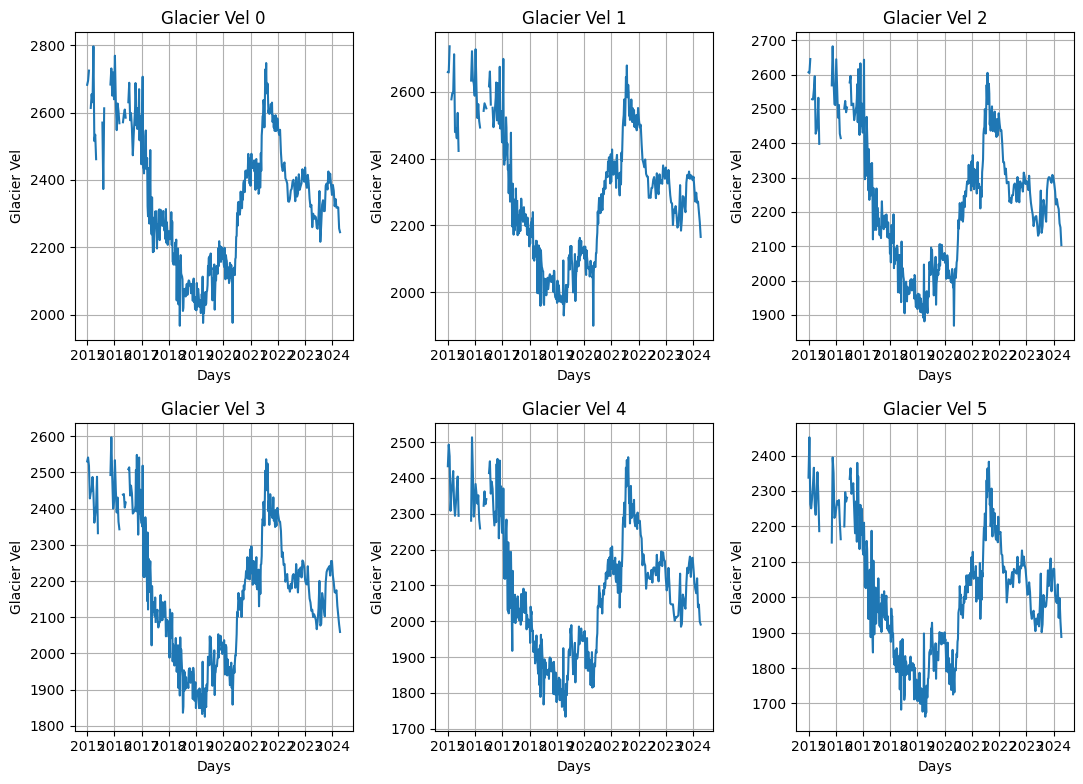

In [29]:
quick_plot(df_wide,n_timeseries,field="Glacier Vel",dt=8)

In [ ]:
torch.cuda.empty_cache()
import gc
gc.collect()

: 

In [30]:
n_predict = 5
time_forecast = n_predict * dt 
print("Forecasting for {} days".format(time_forecast))

Forecasting for 40.0 days


## Predict & Plot forecasts with Chronos

Mean Absolute Error (MAE) for target_0: 42.24474937499999
Mean Absolute Error (MAE) for target_1: 51.846288281250054
Mean Absolute Error (MAE) for target_2: 63.66113656250009
Mean Absolute Error (MAE) for target_3: 68.27394875
Mean Absolute Error (MAE) for target_4: 59.332813359374995
Mean Absolute Error (MAE) for target_5: 54.84119093749996
Mean Absolute Error (MAE) for target_6: 51.02073972656249
Mean Absolute Error (MAE) for target_7: 56.604517070312525
Mean Absolute Error (MAE) for target_8: 60.905154804687484
Mean Absolute Error (MAE) for target_9: 46.845470039062505
Mean Absolute Error (MAE) for target_10: 45.993564921874984
Mean Absolute Error (MAE) for target_11: 51.39334015625
Mean Absolute Error (MAE) for target_12: 63.96544187500003
Mean Absolute Error (MAE) for target_13: 71.486827890625
Mean Absolute Error (MAE) for target_14: 67.60769390625
Mean Absolute Error (MAE) for target_15: 68.74598835937499
Mean Absolute Error (MAE) for target_16: 62.17083863281255
Mean Absolute E

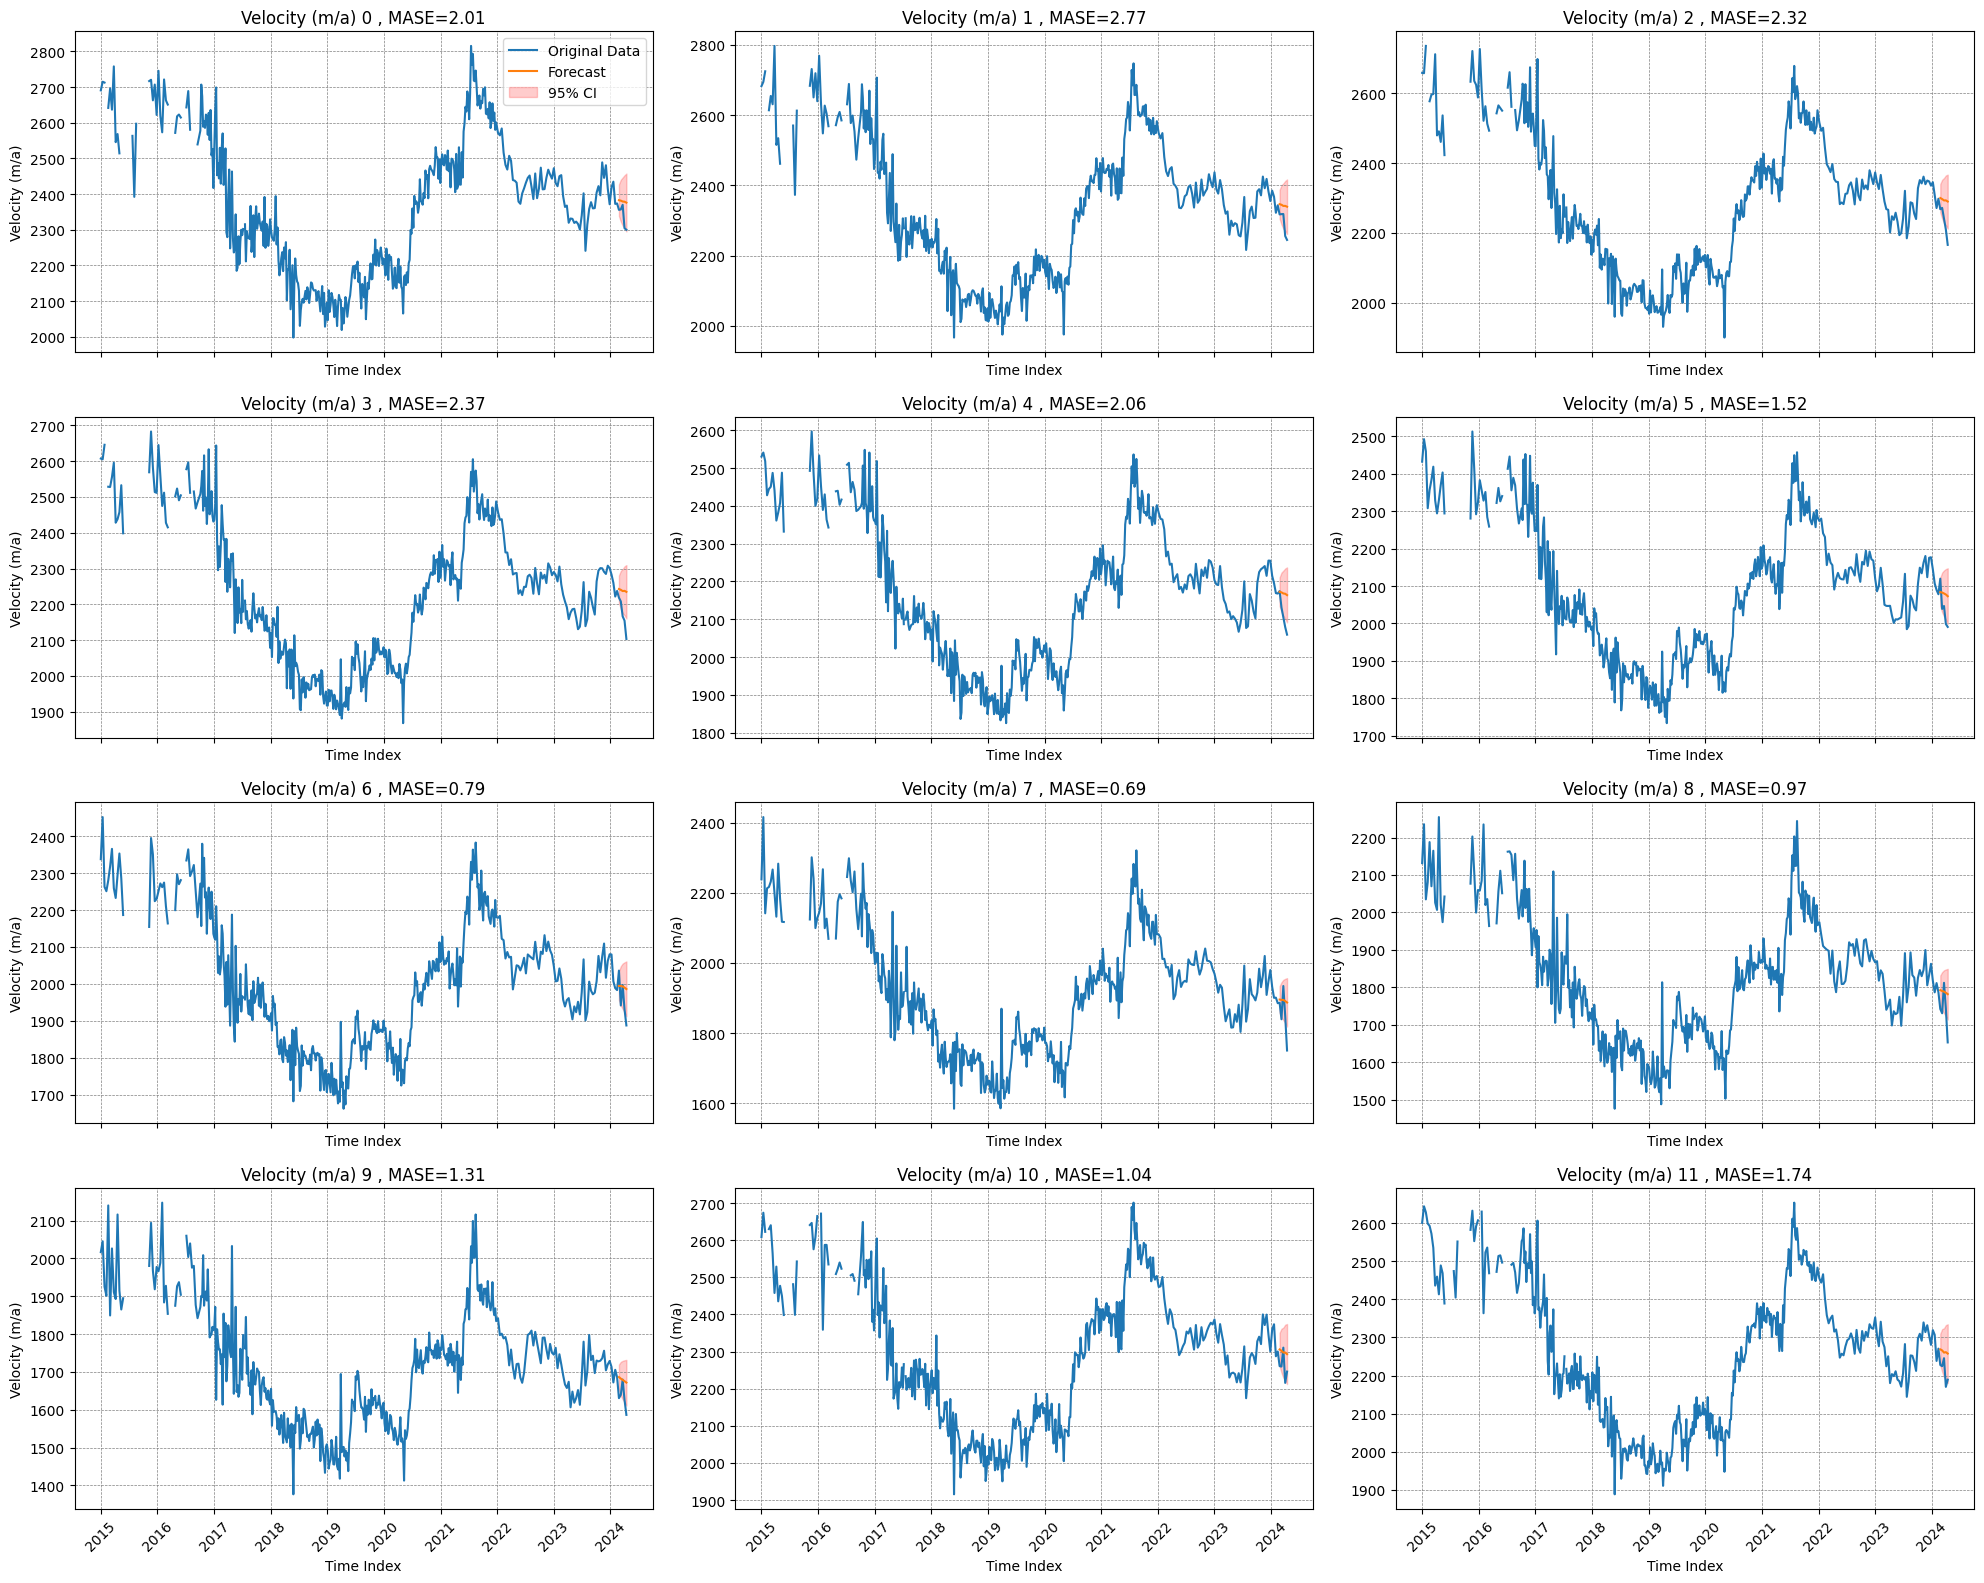

In [31]:
forecast, mean_mae, mean_mase, no_var_mae, split_index = predict_chronos(df_wide,predict_length=n_predict,n_timeseries=n_timeseries)
# plot
plot_forecasts(df_wide,split_index,forecast,n_timeseries,field="Velocity (m/a)",filename="./plots/ice_jakobshavn_forecast.png")

In [ ]:
# benchmarking with ARIMA
# Fit ARIMA model
data = df_wide['target_3'][:split_index]
model = ARIMA(data, order=(5, 2, 1))  # (p, d, q) order, adjust as needed
model_fit = model.fit()

# Make predictions
forecast_steps = 64  # Number of steps to forecast
forecast = model_fit.forecast(steps=forecast_steps)

split_index = len(df_wide['target_3'].values) - 64
print(forecast) 
# calculate the MASE between the forecast and the evaluation data
mase=[]
eval_data = df_wide['target_1'][split_index:]
print(len(df_wide['target_1'].values[split_index:]))
# Calculate and print the MASE for each time series
mase.append(np.mean(np.abs(forecast - df_wide['target_1'].values[split_index:])) / np.mean(np.abs(df_wide['target_1'].values[1:] - df_wide['target_1'].values[:-1])))
# print mase
print(f'Mean Absolute Scaled Error (MASE) for ARIMA: {mase[-1]}')

                 

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(data, label='Actual')
plt.plot(forecast, label='Forecast', color='red')

## 3. Forecasting GPS velocities

In this case, we are going to test Chrono's performance on GPS time series. Vertical components tend to exhibit seasonal loading from precipitation, horizontal components tend to exhibit tectonic processes, especially at plate boundaries.

In [ ]:
# read data from data_gps_P395_relateive_position.csv
fname = "../data/data_gps_P395_relative_position.csv"
df = pd.read_csv(fname)
# convert dacimal year column to floats
df["decimal year"] = df["decimal year"].astype(float)
df.head()

# the date format is in decimal years, convert it to datetime
# df["datetime"] = pd.to_datetime(df["decimal year"], format="%Y.%j")
# df.head()


# perform a running mean average to smooth the data
for ikey in df.keys()[1:]:
    df[ikey]=df[ikey].rolling(window=20).mean()

In [ ]:

sta_name = fname.split("/")[-1].split("_")[2]
print(sta_name)

In [ ]:
# take the first column "decimal year" and convert it to a datetime by taking the year before the comma, then multuply by 365.25 to get the days
df["datetime"] = pd.to_datetime((df["decimal year"] - 1970) * 365.25, unit='D', origin='1970-01-01')
# move the last to the first position
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]
df.head()

In [ ]:
df_list,df_wide = reshape_time_series(df,name_of_target="new delta v (m)", n_timeseries=n_timeseries, duration_years=4)
# now predict with chronos
forecast, mean_mae, mean_mase, no_var_mae, split_index = predict_chronos(df_wide,n_timeseries=n_timeseries)
# plot the forecast
plot_forecasts(df_wide,split_index,forecast,n_timeseries,field="GPS relative position (m)",filename="./plots/gps_"+sta_name+"_v_forecast.png")


#### Horizontal components

In [ ]:
df_list,df_wide = reshape_time_series(df,name_of_target="new delta e (m)", n_timeseries=n_timeseries, duration_years=2)
# now predict with chronos
forecast, mean_mae, mean_mase, no_var_mae, split_index = predict_chronos(df_wide,n_timeseries=n_timeseries)
# plot the forecast
plot_forecasts(df_wide,split_index,forecast,n_timeseries,field="GPS relative position (m)",filename="./plots/gps_"+sta_name+"_e_forecast.png")


In [ ]:
torch.cuda.empty_cache()
import gc
gc.collect()

## 4. Forecast dv/v

In [ ]:
# read one dv/v file
fname = "../data/DVV_data_withMean/Data_BGU.csv"
df = pd.read_csv(fname)
df.head()
sta_name = fname.split("/")[-1].split("_")[1]

In [ ]:
# convert the date into a timestamp
df["datetime"] = pd.to_datetime(df["date"])
# move datetime to the first position
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]

## Predict soil moisture

In [ ]:
df_list,df_wide = reshape_time_series(df,name_of_target="sm_ewt", n_timeseries=n_timeseries, duration_years=4)
# now predict with chronos
forecast, mean_mae, mean_mase, no_var_mae, split_index = predict_chronos(df_wide,n_timeseries=n_timeseries)
# plot the forecast
plot_forecasts(df_wide,split_index,forecast,n_timeseries,field="Soil Moisture",filename="./plots/"+sta_name+"_SM_forecast.png")


In [ ]:
df.keys()

In [ ]:
for ikey in df.keys()[2:]:
    if ikey == "lake":
        # remove mean of the column
        df[ikey] = df[ikey] - df[ikey].mean()
    df_list,df_wide = reshape_time_series(df,name_of_target=ikey, n_timeseries=n_timeseries, duration_years=4)
    # now predict with chronos
    forecast, mean_mae, mean_mase, no_var_mae, split_index = predict_chronos(df_wide,n_timeseries=n_timeseries)
    # plot the forecast
    plot_forecasts(df_wide,split_index,forecast,n_timeseries,field=ikey,filename="./plots/"+sta_name+"_"+ikey+"_forecast.png")

In [ ]:
torch.cuda.empty_cache()
import gc
gc.collect()

## Wave data

In [ ]:
# read CSV file with waveforms in them
df = pd.read_csv("../data/data_waveforms.csv")
df.head()

In [ ]:


# trim data between 100 and 200 rows
df = df.iloc[300:500]
plt.plot(df['time'],df['Z'])

In [ ]:
#make a datetime column
df["datetime"] = pd.to_datetime(df["time"], unit='s')

In [ ]:
df.head()

In [ ]:
df_wide.head()

In [ ]:
df_wide = df
# rename the keys from Z, N, E, to target_0, target_1, target_2
df_wide.columns = ["time","target_0","target_1","target_2","datetime"]

# reset df_wide index:
df_wide = df_wide.reset_index(drop=True)

# create a time_index column that is the index of the time series
df_wide["time_index"] = np.arange(len(df_wide))

# move datetime to the first position
cols = df_wide.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_wide = df_wide[cols]

# drop columns time and datetime
df_wide = df_wide.drop(columns=["time","datetime"])

# # now predict with chronos
forecast, mean_mae, mean_mase, no_var_mae, split_index = predict_chronos(df_wide,predict_length=64, n_timeseries=len(df.keys())-1)
# # plot the forecast
plot_forecasts(df_wide,split_index,forecast,len(df.keys())-1,field="wave",filename="./plots/waveforms_forecast.png")

In [ ]:
# normalize the target data in df_wide to see if this is the problem

df_wide_norm = df_wide.copy()
for ikey in df_wide.keys():
    if ikey != "time_index":
        df_wide_norm[ikey] = (df_wide[ikey] - df_wide[ikey].mean()) / df_wide[ikey].std()


# # now predict with chronos
forecast, mean_mae, mean_mase, no_var_mae, split_index = predict_chronos(df_wide_norm,predict_length=64, n_timeseries=len(df.keys())-1)
# # plot the forecast
plot_forecasts(df_wide_norm,split_index,forecast,len(df.keys())-1,field="wave",filename="./plots/waveforms_forecast_norm.png")

In [ ]:
torch.cuda.empty_cache()
import gc
gc.collect()

## CO2


Here we plan to forecast CO2.

In [ ]:
from datetime import datetime, timedelta
fname = "../data/cleaned_data_co2.csv"
df_co2 = pd.read_csv(fname)


# Function to convert decimal year to datetime
def decimal_year_to_datetime(decimal_year):
    year = int(decimal_year)
    remainder = decimal_year - year
    start_of_year = datetime(year, 1, 1)
    days_in_year = (datetime(year + 1, 1, 1) - start_of_year).days
    return start_of_year + timedelta(days=remainder * days_in_year)

# Apply the function to the 'decimale-date' column
df_co2["datetime"] = df_co2["decimale-date"].apply(decimal_year_to_datetime)


# df_co2["datetime"] = pd.to_datetime((df_co2["decimale-date"] - 1970) * 365.25, origin='1970-01-01', unit='D')
df_co2.head()
# # move datetime to the first position
cols = df_co2.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_co2 = df_co2[cols]
df_co2.head()

In [ ]:
df_list,df_wide = reshape_time_series(df_co2,name_of_target="monthly-average", n_timeseries=n_timeseries, duration_years=20)
# now predict with chronos
forecast, mean_mae, mean_mase, no_var_mae, split_index = predict_chronos(df_wide,n_timeseries=n_timeseries)
# plot the forecast
plot_forecasts(df_wide,split_index,forecast,n_timeseries,field="C02 Moana",filename="./plots/CO2_forecast.png")


## Paleo Climate Benthic D018 time series

This time series is phenomenal because it shows how the system switches from 100ka cycle to 20-40ka cycles. https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2004PA001071

In [ ]:
df_benthic = pd.read_csv("../data/cleaned_lr04.csv")
df_benthic.head()

In [ ]:
fig=plt.figure(figsize=(15, 6))
plt.plot(df_benthic["Time-(ka)"],df_benthic["Benthic-d18O-(per-mil)"])   
plt.xlabel("Time (ka)")
plt.ylabel("Benthic d18O (per mil)")
plt.title("Benthic d18O vs Time")
plt.grid() 

In [ ]:
# add a time_index column to the dataframe
df_benthic["time_index"] = np.arange(len(df_benthic))
# remove Time-(ka) column
df_benthic = df_benthic.drop(columns=["Time-(ka)"])
# move the last to the first position
cols = df_benthic.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_benthic = df_benthic[cols]
df_benthic.head()


In [ ]:
df_benthic_copy.describe()

In [ ]:
# now predict with chronos
df_benthic_copy = df_benthic.iloc[:len(df_benthic)//3]
# rename benthic-d18O-(per-mil) to target_1
df_benthic_copy = df_benthic_copy.rename(columns={"Benthic-d18O-(per-mil)":"target_1"})
forecast, mean_mae, mean_mase, no_var_mae, split_index = predict_chronos(df_benthic_copy,predict_length=64,n_timeseries=1)
# plot the forecast
plot_forecasts(df_benthic_copy,split_index,forecast,1,field="D018",filename="./plots/d018_forecast.png")
